In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models




In [10]:
data = np.load("../data/convlstm_input_ds.npy")

print("Data loaded successfully")
print("Data shape:", data.shape)


Data loaded successfully
Data shape: (14, 2586, 3061, 3)


In [11]:
def extract_patches(data, patch_size=64, stride=64):
    T, H, W, C = data.shape
    patches = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = data[:, i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)

    return np.array(patches)


In [22]:
# Normalize NDVI (-1 to 1) → (0 to 1)
data[..., 0] = (data[..., 0] + 1) / 2

# Normalize wind speed
data[..., 1] = (data[..., 1] - data[..., 1].mean()) / data[..., 1].std()

# Normalize relative humidity
data[..., 2] = data[..., 2] / 100.0


In [12]:
patches = extract_patches(data, patch_size=64, stride=64)

print("Patches created")
print("Patches shape:", patches.shape)


Patches created
Patches shape: (1880, 14, 64, 64, 3)


In [13]:
X = patches[:, :-1, :, :, :]     # First 13 days
y = patches[:, -1, :, :, 0:1]    # Day 14 NDVI only

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1880, 13, 64, 64, 3)
y shape: (1880, 64, 64, 1)


In [14]:
num_samples = X.shape[0]
split = int(0.8 * num_samples)

X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 1504
Validation samples: 376


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, ConvLSTM2D, BatchNormalization, Conv2D
)

# Input shape: (time_steps, height, width, channels)
input_layer = Input(shape=(13, 64, 64, 3))

x = ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh"
)(input_layer)
x = BatchNormalization()(x)

x = ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=False,
    activation="tanh"
)(x)
x = BatchNormalization()(x)

# Predict next-day NDVI
output = Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation="linear",
    padding="same"
)(x)

model = Model(inputs=input_layer, outputs=output)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 13, 64, 64, 32) │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 64, 64, 16)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 1)      │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,369 (267.07 KB)

 Trainable params: 68,273 (266.69 KB)

 Non-trainable params: 96 (384.00 B)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

print("Model compiled successfully")


Model compiled successfully


In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4,
    verbose=1
)


Epoch 1/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - loss: 669.8135 - mae: 0.4164 - val_loss: 1674.8590 - val_mae: 0.5922
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 328s 865ms/step - loss: 669.7964 - mae: 0.3800 - val_loss: 1675.4298 - val_mae: 0.9048
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 340s 904ms/step - loss: 669.7048 - mae: 0.3561 - val_loss: 1675.0974 - val_mae: 0.6006
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 334s 888ms/step - loss: 669.6574 - mae: 0.3701 - val_loss: 1678.1454 - val_mae: 1.5384
Epoch 5/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 351s 934ms/step - loss: 669.6143 - mae: 0.3558 - val_loss: 1676.3175 - val_mae: 1.3795


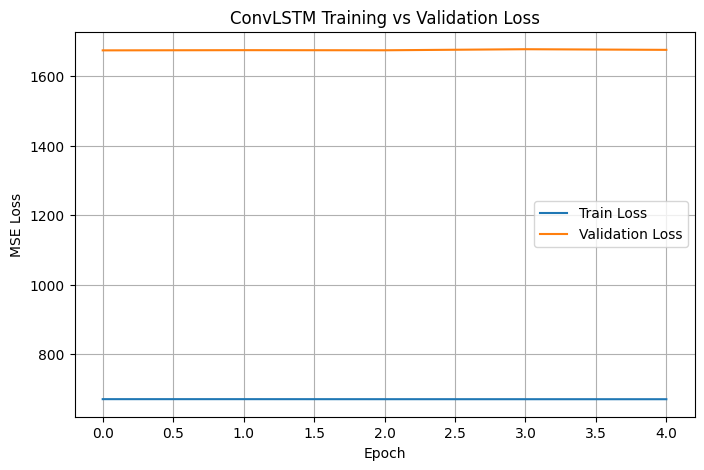

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("ConvLSTM Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
y_pred = model.predict(X_val, batch_size=4)

print("Prediction shape:", y_pred.shape)


94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step
Prediction shape: (376, 64, 64, 1)


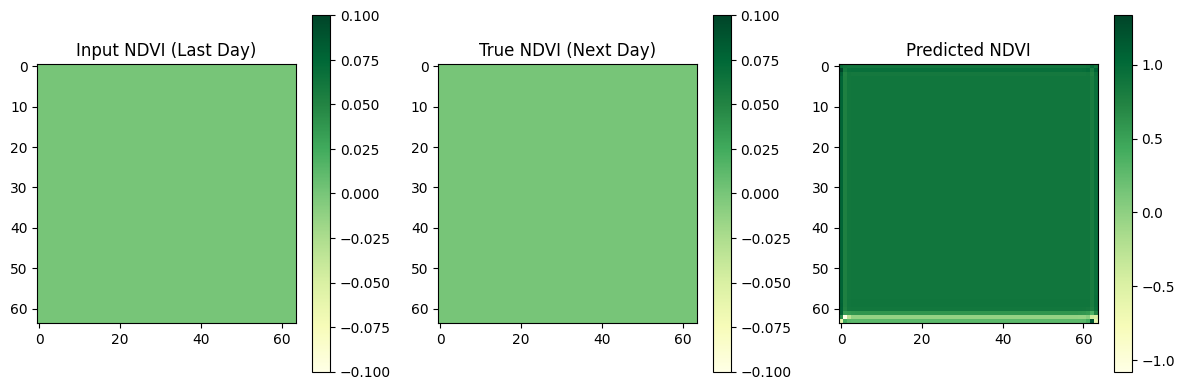

In [21]:
idx = 0  # first validation sample

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input NDVI (Last Day)")
plt.imshow(X_val[idx, -1, :, :, 0], cmap="YlGn")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("True NDVI (Next Day)")
plt.imshow(y_val[idx, :, :, 0], cmap="YlGn")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Predicted NDVI")
plt.imshow(y_pred[idx, :, :, 0], cmap="YlGn")
plt.colorbar()

plt.tight_layout()
plt.show()


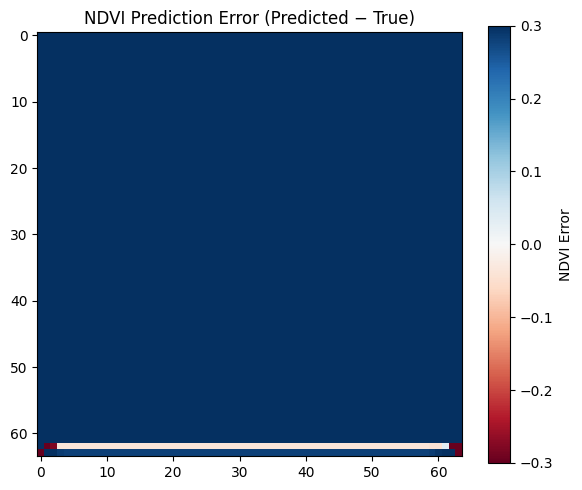

In [23]:
idx = 0  # validation sample index

error_map = y_pred[idx, :, :, 0] - y_val[idx, :, :, 0]

plt.figure(figsize=(6, 5))
plt.title("NDVI Prediction Error (Predicted − True)")
plt.imshow(error_map, cmap="RdBu")
plt.colorbar(label="NDVI Error")
plt.clim(-0.3, 0.3)
plt.tight_layout()
plt.show()


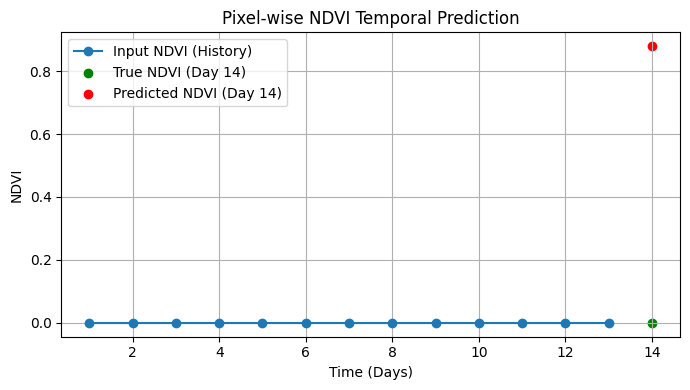

In [24]:
# Select a pixel from the center of the patch
h, w = 32, 32  

true_series = X_val[idx, :, h, w, 0]        # input NDVI (13 days)
true_next = y_val[idx, h, w, 0]              # actual next-day NDVI
pred_next = y_pred[idx, h, w, 0]             # predicted NDVI

plt.figure(figsize=(7, 4))
plt.plot(range(1, 14), true_series, marker="o", label="Input NDVI (History)")
plt.scatter(14, true_next, color="green", label="True NDVI (Day 14)")
plt.scatter(14, pred_next, color="red", label="Predicted NDVI (Day 14)")

plt.xlabel("Time (Days)")
plt.ylabel("NDVI")
plt.title("Pixel-wise NDVI Temporal Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


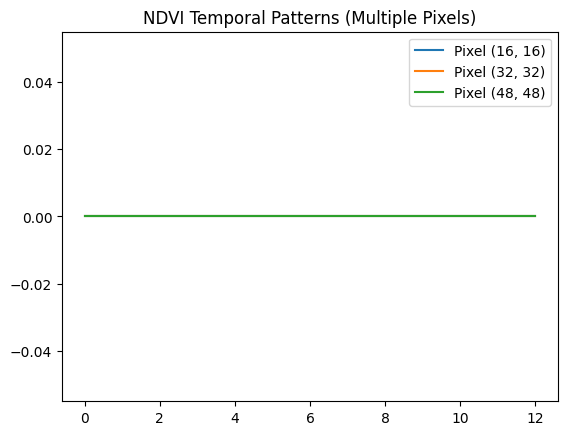

In [25]:
for idx_pix in [(16,16), (32,32), (48,48)]:
    h, w = idx_pix
    plt.plot(X_val[0, :, h, w, 0], label=f"Pixel {idx_pix}")

plt.legend()
plt.title("NDVI Temporal Patterns (Multiple Pixels)")
plt.show()


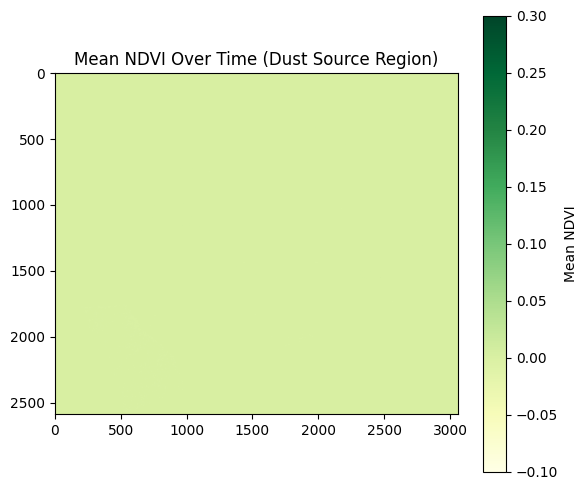

In [28]:
# Convert scaled NDVI to real NDVI
mean_ndvi_real = (data[..., 0] / 10000.0).mean(axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.title("Mean NDVI Over Time (Dust Source Region)")
plt.imshow(mean_ndvi_real, cmap="YlGn", vmin=-0.1, vmax=0.3)
plt.colorbar(label="Mean NDVI")
plt.tight_layout()
plt.show()


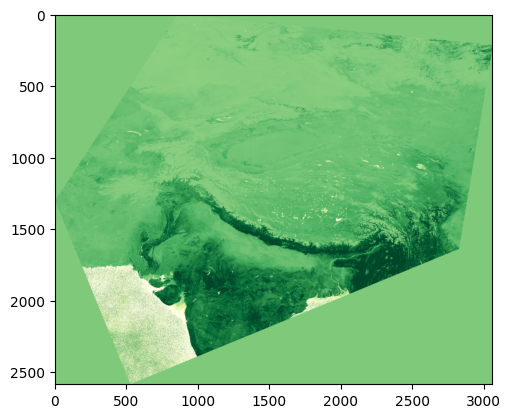

In [30]:
plt.imshow(mean_ndvi_real, cmap="YlGn",
           vmin=np.percentile(mean_ndvi_real, 2),
           vmax=np.percentile(mean_ndvi_real, 98))
